# Train a Model to Detect Breast MRI tumors with Deep Learning and PyTorch: Part 2

This is the second part of my tutorial series on how to train a neural network classifier to detect tumors in breast MRI images, using PyTorch. In the first part {} I introduced my lab's [Breast MRI dataset](https://wiki.cancerimagingarchive.net/pages/viewpage.action?pageId=70226903), and how to interact with raw medical imaging data using Python. I demonstrated how to extract and sort image files in a format and labeling that will be useful for training and testing our model with PyTorch. 

With our data in place, we can proceed to building, training and testing our deep classifier.

All code for this series can be found [here](https://github.com/mazurowski-lab/MRI-deeplearning-tutorialhttps://github.com/mazurowski-lab/MRI-deeplearning-tutorial).

## (1) Building a data loading pipeline

Deep learning is data-driven, so having a reliable framework to work with (image) data is essential. PyTorch (the `torch` and `torchvision` libraries in Python), among other things, allows for the efficient manipulation and management of numerical matrices, and is one of the most popular deep learning frameworks (as neural networks operate and learn via many matrix multiplications and additions). Images can also be describes with large matrices of numbers, where the dimensions of the matrices correspond to the size of the image, and each element of the matrix is a pixel intensity value. As such, it is extremely helpful to abstract all image data loading/processing and neural networks operations with PyTorch, which comes with myriad convenient modules and tools for these and more.

The central objects that we will use are the `Dataset` and `DataLoader` of `torch.utils.data`. While `Dataset` allows for the easy storage and indexing of data samples and labels, `DataLoader` makes it possible to easily access these samples in a way that integrates very well with how we will train and test neural networks. Please see PyTorch's [tutorial](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) for more information. To start, lets import the needed libaries and objects:

In [1]:
# first, load the same libraries as in Part 1
import pandas as pd
import numpy as np
import os
import pydicom
from tqdm import tqdm
from skimage.io import imsave

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from skimage.io import imread

Next, let's define some constants:

In [2]:
# directory where our .png data is (outputted from the previous part)
data_dir = 'png_out'
# length in pixels of size of image once resized for the network
img_size = 128 

### Datasets


First, we must define our own `Dataset` for the DBC dataset, called `DBCDataset`. In summary, the important methods defined in `DBCDataset` are:
1. the `create_labels()` method assigns an easily-accessible label to each image in the dataset, 
2. the `normalize()` method normalizes images to the pixel value range `[0,255]`, as it's important to standardize data for deep learning, 
3. the `__getitem__()` method is required for `Dataset`s, and describes how data is obtained from the dataset with an index (or indices)

Check out the code block below, where I've added comments to explain each step.  

In [3]:
class DBCDataset(Dataset):
    def __init__(self):
        self.data_dir = data_dir
        self.img_size = img_size
        
        # assign labels to data within this Dataset
        self.labels = None
        self.create_labels()

    def create_labels(self):
        # create and store a label (positive/1 or negative/0 for each image)
        # each label is the tuple: (img filename, label number (0 or 1))
        labels = []
        print('building DBC dataset labels.')
        # iterate over each class
        for target, target_label in enumerate(['neg', 'pos']):
            case_dir = os.path.join(self.data_dir, target_label)
            # iterate over all images in the class/case type
            for fname in os.listdir(case_dir):
                if '.png' in fname:
                    fpath = os.path.join(case_dir, fname)
                    labels.append((fpath, target))
            
        self.labels = labels

                 
    def normalize(self, img):
        # normalize image pixel values to range [0, 255]
        # img expected to be array
                 
        # convert uint16 -> float
        img = img.astype(np.float) * 255. / img.max()
        # convert float -> unit8
        img = img.astype(np.uint8)
        
        return img
    
    def __getitem__(self, idx):
        # required method for accessing data samples
        # returns data with its label
        fpath, target  = self.labels[idx]
        
        # load img from file (png or jpg)
        img_arr = imread(fpath, as_gray=True)
        
        # normalize image
        img_arr = self.normalize(img_arr)
        
        # convert to tensor (PyTorch matrix)
        data = torch.from_numpy(img_arr)
        data = data.type(torch.FloatTensor) 
       
        # add image channel dimension (to work with neural network)
        data = torch.unsqueeze(data, 0)
        
        # resize image
        data = transforms.Resize((self.img_size, self.img_size))(data)
        
        return data, target

    def __len__(self):
        # required method for getting size of dataset
        return len(self.labels)

From here we can simply create an instance of the dataset with:

In [4]:
dataset = DBCDataset()
print(len(dataset))

building DBC dataset labels.
5200


### Training, validation and test sets: what are the differences?
To develop our classification model we will need to split our dataset into training, validation, and test sets. For each image in the datapoint, there is an associated label that we want the classification model to predict. But what are the differences between these data subsets?
1. The training set is used to provide the model with examples for how to make predictions; this is what the model "learns" from. The learning algorithm is just modifying the neural network parameters to minimize the average prediction error on the training set.
2. The validation set is used to estimate how well the model performs on predicting labels for new data that it has not learned from (the ultimate goal of developing this model, also known as *generalization*). This validation prediction error is used to select at which point in training we'd like to save the model: we want to save the model when the validation error is lowest. You can also use the validation set to select *hyperparameters* or settings for the training algorithm that are not learned from the training set.
3. The test set, like the validation set, is also used to estimate the *generalization ability* of the neural network on new data; however, this must be separate from the validation set because the validation set itself was used to select the final model, and we want an unbiased estimate of generalization ability


With a dataset size of 2600 + 2600 = 5200, a typical set of percentages for splitting the dataset into training/validation/testing could be something like 80%/10%/10%, which results in a training set of size 4160, and validation and testing set sizes of 520, each. Practically, we can extract these subsets from our dataset with the useful function `torch.utils.data.random_split()`, which randomly splits up the full dataset into subsets:

In [5]:
train_fraction = 0.8
validation_fraction = 0.1
test_fraction = 0.1
dataset_size = len(dataset)
[print(dataset_size)]

num_train = int(train_fraction * dataset_size)
num_validation = int(validation_fraction * dataset_size)
num_test = int(test_fraction * dataset_size)
print(num_train, num_validation, num_test)

#subset_sizes = [train_fraction * dataset_size, validation_fraction * dataset_size, test_fraction * dataset_size]
#subset_sizes = [np.floor(s) for s in subset_sizes]
#print(subset_sizes)

train_dataset, validation_dataset, test_dataset = torch.utils.data.random_split(dataset, [num_train, num_validation, num_test])

5200
4160 520 520


### Dataloaders
We've created PyTorch `Dataset`s for model training, validation and testing, which is most of the work for our data-loading pipeline. To finish, we will need to create PyTorch `Dataloader`s to conveniently access images from our datasets. But first, a quick note on *batch sizes*.

#### Batch sizes and computation devices
While we could train neural networks on one image at a time, this would be prohibitively slow, as they usually require learning from hundreds or thousands of images, many times. Instead, we can train on *batches* of multiple images at the same time, limited by the memory capacity of our computation processing device; for example, GPUs (graphical processing units), which are specially designed for image manipulation.

Below, we will create `Dataloaders` for each of our three data subsets. We will use a batch size of 200 for the training set, but this is very much dependent on the CPU or GPU hardware that you use for computations. For most realistic computer vision applications, a GPU is required, as CPUs are intractably slow; as such, we will be using an 8 GB NVIDIA GTX 1070. The device that we will load data on to can be specified with:

In [6]:
# GPUs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('running on {}'.format(device))

running on cuda


Now, let's create our dataloaders:


In [7]:
train_batchsize = 200
eval_batchsize = 10
train_loader = DataLoader(train_dataset, 
                                     batch_size=train_batchsize, 
                                     shuffle=True
                                     # images are loaded in random order
                                                )
                                                
validation_loader = DataLoader(validation_dataset, 
                        batch_size=eval_batchsize)

test_loader = DataLoader(test_dataset, 
                        batch_size=eval_batchsize)

Next, to ensure that our results will be reproducible, we will fix all random seeds with:

In [8]:
# set random seeds for reproducibility
import random
seed = 42
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

With this, we are ready to introduce and build our classification neural network!

## (2) Loading a neural network
Neural networks are really just functions with many, many parameters (a.k.a. dials to tune). These parameters are *learned* from lots of data to tune the network to best approximate the function that we're trying to emulate. For example, an image classification neural network, like the one we will work with, is trained to take images as input, and output the correct class identity of the image, e.g., whether a breast image is cancerous. The many successive computational *layers* of neural networks allow them to learn very complicated functions that would be practically impossible to hand-design.

*Convolutional* neural networks were particularly designed to learn to detect the spatial patterns found in images, so are especially well-suited for our task. Today, we will work with a very popular modern neural network architecture called a residual network, or *ResNet* for short. In fact, the original [ResNet paper](https://arxiv.org/abs/1512.03385) is one of the most cited papers of all time, with over 120,000 citations as of June 2022, according to Google Scholar. We will be using a particular version of the ResNet *model* known as ResNet-18, the details of which are beyond the scope of this tutorial. ResNet-18 and models like it can be easily loaded (untrained) with PyTorch's `torchvision.models` library, as:

In [9]:
from torchvision.models import resnet18
from torch import nn

Here we also imported PyTorch's neural network library `torch.nn`. Next, we will load a ResNet-18 to work with (as `resnet18` is a class):

In [10]:
net = resnet18()

ResNets are designed to work with color, three-channel images. However, our MRI slices are one-channel, so we will need to modify our `net` to take one-channel inputs. This can be accomplished by modifying the *input layer* of `net` as:

In [11]:
net.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

Finally, we need to load the net onto our computation device:

In [12]:
net = net.to(device)

With that, our network is ready to be trained to classify our images. Let's set up a training pipeline!

## (3) Setting up for training
Neural networks "learn" by minimizing the average error of making predictions on the entire training set. Each iteration, or *epoch*, over the training set, the parameters are adjusted in order to perform better at the next iteration. The change for each parameter is determined by the *backpropagation* algorithm, which adjusts each parameter to make the steepest decrease in error at the given iteration, over average (this process is known as *stochastic gradient descent* or "SGD").

There are a couple of things that we will need to define in order to make this happen. First, we must define this prediction error, also known as *loss*. For the task of classification, the loss that we need is `nn.CrossEntropyLoss()`, which increases as the network predicts more incorrect classification of images in the training set. This is what we want to minimize in training; we can define it as:

In [13]:
criterion = nn.CrossEntropyLoss()

Next, we want to define the *error minimization* algorithm that we will use; again, this *is stochastic gradient descent*, or SGD; there are others of course, but SGD is the most basic and will serve fine. When creating an instance of SGD, we will need to tell it which parameters we will minimize (the parameters of `net`, and the *learning rate*. The learning rate (`lr`) is a fixed constant, that basically determines the approximate size of adjustments made to parameters during learning. A good choice of learning rate can vary depending on the task, data, network and other factors, but for now, we will choose `lr=0.001`.

In [14]:
error_minimizer = torch.optim.SGD(net.parameters(), lr=0.001)

Finally, let's set the number of training epochs (passes over the entire training set) to 100:


In [15]:
epochs = 100


## (4) Train and validate your model!


We now have everything that we need to train our classification model. As mentioned earlier, on each training epoch we can evaluate the model on the validation dataset to estimate how well it will perform on unseen data. Then, we save our final trained model as the model found to have the best performance/classification accuracy on the validation set during training.

To do this in practice, we can create a copy of our training model `net`, and save it as a separate network `net_final`. Let's go ahead and initialize that:


In [16]:
from copy import deepcopy
net_final = deepcopy(net)

Finally, we can create and run our training loop, with everything that we discussed earlier, in the code below (with comments at each step). In practice, we will use classification accuracy as our measure of prediction error, i.e., the percentage of images in the given dataset that are classified correctly by the network. One subtlety to deal with is that the network actually outputs *probabilities* for the input image being in each class. As such, the single predicted class is just given by the highest probability class.

We can also store our accuracy vs. epoch data for the training and validation sets, in order to observe how the model evolves through training.

Alright, let's go ahead and train our model! This may take some time, depending on the strength of your computation device.

In [17]:
best_validation_accuracy = 0. # used to pick the best-performing model on the validation set

# for training visualization later
train_accs = []
val_accs = []

# training loop
for epoch in range(epochs):
	# set network to training mode, so that its parameters can be changed
	net.train()

	# print training info
	print("### Epoch {}:".format(epoch))


	# statistics needed to compute classification accuracy:
	# the total number of image examples trained on
	total_train_examples = 0

	# the number of examples classified correctly
	num_correct_train = 0

	# iterate over the training set once
	for batch_index, (inputs, targets) in tqdm(enumerate(train_loader), total=len(train_dataset)//train_batchsize):
		# load the data onto the computation device.
		# inputs are a tensor of shape (batch size, number of channels, image height, image width).
		# targets are a tensor of one-hot-encoded class labels for the inputs, of shape (batch size, number of classes)
		# in other words, 
		inputs = inputs.to(device)
		targets = targets.to(device)

		# reset changes (gradients) to parameters
		error_minimizer.zero_grad()

		# get the network's predictions on the training set batch
		predictions = net(inputs)

		# evaluate the error, and estimate how much to change the network parameters by
		loss = criterion(predictions, targets)
		loss.backward()

		# change parameters
		error_minimizer.step()

		# calculate predicted class label
		# the .max() method returns the maximum entries, and their indices;
		# we just need to index with the highest probability, not the probability itself.
		_, predicted_class = predictions.max(1)
		total_train_examples += predicted_class.size(0)
		num_correct_train += predicted_class.eq(targets).sum().item()

	# get results
	# total prediction accuracy of network on training set
	train_acc = num_correct_train / total_train_examples
	print("Training accuracy: {}".format(train_acc))
	train_accs.append(train_acc)



	# predict on validation set (similar to training set):
	total_val_examples = 0
	num_correct_val = 0

	# switch network from training mode (parameters can be trained) to evaluation mode (parameters can't be trained)
	net.eval()

	with torch.no_grad(): # don't save parameter gradients/changes since this is not for model training
		for batch_index, (inputs, targets) in tqdm(enumerate(validation_loader), total=len(validation_dataset)//eval_batchsize):
			inputs = inputs.to(device)
			targets = targets.to(device)
			predictions = net(inputs)

			_, predicted_class = predictions.max(1)
			total_val_examples += predicted_class.size(0)
			num_correct_val += predicted_class.eq(targets).sum().item()

	# get results
	# total prediction accuracy of network on validation set
	val_acc = num_correct_val / total_val_examples
	print("Validation accuracy: {}".format(val_acc))
	val_accs.append(val_acc)


	# Finally, save model if the validation accuracy is the best so far
	if val_acc > best_validation_accuracy:
		best_validation_accuracy = val_acc
		print("Validation accuracy improved; saving model.")
		net_final = deepcopy(net)

### Epoch 0:


  0%|                                                                         | 0/20 [00:00<?, ?it/s]/tmp/ipykernel_620/11095997.py:32: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  img = img.astype(np.float) * 255. / img.max()
21it [00:16,  1.30it/s]                                                                              


Training accuracy: 0.23557692307692307


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 29.09it/s]


Validation accuracy: 0.5153846153846153
Validation accuracy improved; saving model.
### Epoch 1:


21it [00:15,  1.37it/s]                                                                              


Training accuracy: 0.5454326923076923


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 28.46it/s]


Validation accuracy: 0.551923076923077
Validation accuracy improved; saving model.
### Epoch 2:


21it [00:15,  1.39it/s]                                                                              


Training accuracy: 0.5677884615384615


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 29.14it/s]


Validation accuracy: 0.575
Validation accuracy improved; saving model.
### Epoch 3:


21it [00:15,  1.37it/s]                                                                              


Training accuracy: 0.604326923076923


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 29.25it/s]


Validation accuracy: 0.5903846153846154
Validation accuracy improved; saving model.
### Epoch 4:


21it [00:15,  1.37it/s]                                                                              


Training accuracy: 0.6233173076923076


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 28.97it/s]


Validation accuracy: 0.6115384615384616
Validation accuracy improved; saving model.
### Epoch 5:


21it [00:15,  1.39it/s]                                                                              


Training accuracy: 0.661298076923077


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 28.59it/s]


Validation accuracy: 0.625
Validation accuracy improved; saving model.
### Epoch 6:


21it [00:15,  1.39it/s]                                                                              


Training accuracy: 0.6790865384615384


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 28.93it/s]


Validation accuracy: 0.65
Validation accuracy improved; saving model.
### Epoch 7:


21it [00:15,  1.38it/s]                                                                              


Training accuracy: 0.7045673076923077


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 28.24it/s]


Validation accuracy: 0.6711538461538461
Validation accuracy improved; saving model.
### Epoch 8:


21it [00:15,  1.37it/s]                                                                              


Training accuracy: 0.7367788461538461


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 28.38it/s]


Validation accuracy: 0.6846153846153846
Validation accuracy improved; saving model.
### Epoch 9:


21it [00:15,  1.37it/s]                                                                              


Training accuracy: 0.7435096153846154


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 28.74it/s]


Validation accuracy: 0.6923076923076923
Validation accuracy improved; saving model.
### Epoch 10:


21it [00:15,  1.37it/s]                                                                              


Training accuracy: 0.7586538461538461


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 27.71it/s]


Validation accuracy: 0.7192307692307692
Validation accuracy improved; saving model.
### Epoch 11:


21it [00:15,  1.36it/s]                                                                              


Training accuracy: 0.7713942307692307


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 28.64it/s]


Validation accuracy: 0.725
Validation accuracy improved; saving model.
### Epoch 12:


21it [00:16,  1.30it/s]                                                                              


Training accuracy: 0.7759615384615385


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 26.55it/s]


Validation accuracy: 0.7365384615384616
Validation accuracy improved; saving model.
### Epoch 13:


21it [00:15,  1.35it/s]                                                                              


Training accuracy: 0.7891826923076923


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 28.78it/s]


Validation accuracy: 0.7461538461538462
Validation accuracy improved; saving model.
### Epoch 14:


21it [00:15,  1.39it/s]                                                                              


Training accuracy: 0.7987980769230769


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 28.62it/s]


Validation accuracy: 0.7346153846153847
### Epoch 15:


21it [00:14,  1.41it/s]                                                                              


Training accuracy: 0.8026442307692307


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 28.99it/s]


Validation accuracy: 0.75
Validation accuracy improved; saving model.
### Epoch 16:


21it [00:15,  1.39it/s]                                                                              


Training accuracy: 0.8091346153846154


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 28.21it/s]


Validation accuracy: 0.7596153846153846
Validation accuracy improved; saving model.
### Epoch 17:


21it [00:15,  1.38it/s]                                                                              


Training accuracy: 0.8134615384615385


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 28.60it/s]


Validation accuracy: 0.7711538461538462
Validation accuracy improved; saving model.
### Epoch 18:


21it [00:15,  1.37it/s]                                                                              


Training accuracy: 0.8144230769230769


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 28.30it/s]


Validation accuracy: 0.7730769230769231
Validation accuracy improved; saving model.
### Epoch 19:


21it [00:15,  1.38it/s]                                                                              


Training accuracy: 0.8247596153846154


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 28.40it/s]


Validation accuracy: 0.7826923076923077
Validation accuracy improved; saving model.
### Epoch 20:


21it [00:15,  1.37it/s]                                                                              


Training accuracy: 0.8264423076923076


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 28.50it/s]


Validation accuracy: 0.7730769230769231
### Epoch 21:


21it [00:15,  1.38it/s]                                                                              


Training accuracy: 0.83125


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 28.59it/s]


Validation accuracy: 0.7846153846153846
Validation accuracy improved; saving model.
### Epoch 22:


21it [00:15,  1.38it/s]                                                                              


Training accuracy: 0.8382211538461538


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 28.70it/s]


Validation accuracy: 0.7884615384615384
Validation accuracy improved; saving model.
### Epoch 23:


21it [00:15,  1.39it/s]                                                                              


Training accuracy: 0.8355769230769231


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 28.93it/s]


Validation accuracy: 0.7923076923076923
Validation accuracy improved; saving model.
### Epoch 24:


21it [00:15,  1.37it/s]                                                                              


Training accuracy: 0.8449519230769231


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 27.79it/s]


Validation accuracy: 0.775
### Epoch 25:


21it [00:15,  1.38it/s]                                                                              


Training accuracy: 0.8471153846153846


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 28.91it/s]


Validation accuracy: 0.7942307692307692
Validation accuracy improved; saving model.
### Epoch 26:


21it [00:15,  1.37it/s]                                                                              


Training accuracy: 0.8483173076923077


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 28.81it/s]


Validation accuracy: 0.7942307692307692
### Epoch 27:


21it [00:15,  1.37it/s]                                                                              


Training accuracy: 0.8552884615384615


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 28.98it/s]


Validation accuracy: 0.7942307692307692
### Epoch 28:


21it [00:15,  1.38it/s]                                                                              


Training accuracy: 0.8548076923076923


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 28.45it/s]


Validation accuracy: 0.7961538461538461
Validation accuracy improved; saving model.
### Epoch 29:


21it [00:15,  1.37it/s]                                                                              


Training accuracy: 0.8588942307692308


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 28.30it/s]


Validation accuracy: 0.8153846153846154
Validation accuracy improved; saving model.
### Epoch 30:


21it [00:15,  1.37it/s]                                                                              


Training accuracy: 0.8658653846153846


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 28.54it/s]


Validation accuracy: 0.7942307692307692
### Epoch 31:


21it [00:15,  1.37it/s]                                                                              


Training accuracy: 0.865625


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 27.93it/s]


Validation accuracy: 0.8057692307692308
### Epoch 32:


21it [00:15,  1.37it/s]                                                                              


Training accuracy: 0.8689903846153846


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 28.20it/s]


Validation accuracy: 0.8153846153846154
### Epoch 33:


21it [00:15,  1.37it/s]                                                                              


Training accuracy: 0.875


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 27.15it/s]


Validation accuracy: 0.8211538461538461
Validation accuracy improved; saving model.
### Epoch 34:


21it [00:15,  1.37it/s]                                                                              


Training accuracy: 0.8783653846153846


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 28.28it/s]


Validation accuracy: 0.8153846153846154
### Epoch 35:


21it [00:15,  1.38it/s]                                                                              


Training accuracy: 0.8834134615384616


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 28.39it/s]


Validation accuracy: 0.8211538461538461
### Epoch 36:


21it [00:15,  1.38it/s]                                                                              


Training accuracy: 0.8841346153846154


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 28.46it/s]


Validation accuracy: 0.825
Validation accuracy improved; saving model.
### Epoch 37:


21it [00:15,  1.38it/s]                                                                              


Training accuracy: 0.8889423076923076


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 28.53it/s]


Validation accuracy: 0.8288461538461539
Validation accuracy improved; saving model.
### Epoch 38:


21it [00:15,  1.38it/s]                                                                              


Training accuracy: 0.8891826923076923


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 28.50it/s]


Validation accuracy: 0.8288461538461539
### Epoch 39:


21it [00:15,  1.36it/s]                                                                              


Training accuracy: 0.8961538461538462


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 27.33it/s]


Validation accuracy: 0.8288461538461539
### Epoch 40:


21it [00:15,  1.37it/s]                                                                              


Training accuracy: 0.9019230769230769


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 28.35it/s]


Validation accuracy: 0.8307692307692308
Validation accuracy improved; saving model.
### Epoch 41:


21it [00:15,  1.39it/s]                                                                              


Training accuracy: 0.9021634615384615


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 28.42it/s]


Validation accuracy: 0.8307692307692308
### Epoch 42:


21it [00:15,  1.37it/s]                                                                              


Training accuracy: 0.9079326923076924


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 28.86it/s]


Validation accuracy: 0.8384615384615385
Validation accuracy improved; saving model.
### Epoch 43:


21it [00:15,  1.39it/s]                                                                              


Training accuracy: 0.9076923076923077


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 28.81it/s]


Validation accuracy: 0.8384615384615385
### Epoch 44:


21it [00:15,  1.39it/s]                                                                              


Training accuracy: 0.9115384615384615


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 28.95it/s]


Validation accuracy: 0.8461538461538461
Validation accuracy improved; saving model.
### Epoch 45:


21it [00:15,  1.39it/s]                                                                              


Training accuracy: 0.9199519230769231


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 29.04it/s]


Validation accuracy: 0.8403846153846154
### Epoch 46:


21it [00:15,  1.38it/s]                                                                              


Training accuracy: 0.9201923076923076


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 29.16it/s]


Validation accuracy: 0.8403846153846154
### Epoch 47:


21it [00:15,  1.38it/s]                                                                              


Training accuracy: 0.9233173076923077


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 28.83it/s]


Validation accuracy: 0.8480769230769231
Validation accuracy improved; saving model.
### Epoch 48:


21it [00:15,  1.38it/s]                                                                              


Training accuracy: 0.9254807692307693


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 28.69it/s]


Validation accuracy: 0.85
Validation accuracy improved; saving model.
### Epoch 49:


21it [00:15,  1.38it/s]                                                                              


Training accuracy: 0.9336538461538462


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 29.07it/s]


Validation accuracy: 0.85
### Epoch 50:


21it [00:15,  1.38it/s]                                                                              


Training accuracy: 0.934375


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 29.01it/s]


Validation accuracy: 0.85
### Epoch 51:


21it [00:15,  1.39it/s]                                                                              


Training accuracy: 0.9394230769230769


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 28.97it/s]


Validation accuracy: 0.8519230769230769
Validation accuracy improved; saving model.
### Epoch 52:


21it [00:15,  1.38it/s]                                                                              


Training accuracy: 0.9413461538461538


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 28.28it/s]


Validation accuracy: 0.8519230769230769
### Epoch 53:


21it [00:15,  1.38it/s]                                                                              


Training accuracy: 0.9454326923076923


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 28.37it/s]


Validation accuracy: 0.8557692307692307
Validation accuracy improved; saving model.
### Epoch 54:


21it [00:15,  1.39it/s]                                                                              


Training accuracy: 0.9461538461538461


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 28.31it/s]


Validation accuracy: 0.8557692307692307
### Epoch 55:


21it [00:15,  1.36it/s]                                                                              


Training accuracy: 0.9507211538461539


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 28.82it/s]


Validation accuracy: 0.8557692307692307
### Epoch 56:


21it [00:15,  1.39it/s]                                                                              


Training accuracy: 0.953125


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 29.21it/s]


Validation accuracy: 0.8596153846153847
Validation accuracy improved; saving model.
### Epoch 57:


21it [00:15,  1.39it/s]                                                                              


Training accuracy: 0.9538461538461539


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 29.12it/s]


Validation accuracy: 0.8615384615384616
Validation accuracy improved; saving model.
### Epoch 58:


21it [00:14,  1.40it/s]                                                                              


Training accuracy: 0.9572115384615385


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 28.99it/s]


Validation accuracy: 0.8711538461538462
Validation accuracy improved; saving model.
### Epoch 59:


21it [00:15,  1.40it/s]                                                                              


Training accuracy: 0.9586538461538462


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 28.94it/s]


Validation accuracy: 0.8730769230769231
Validation accuracy improved; saving model.
### Epoch 60:


21it [00:15,  1.39it/s]                                                                              


Training accuracy: 0.9615384615384616


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 29.04it/s]


Validation accuracy: 0.8730769230769231
### Epoch 61:


21it [00:15,  1.39it/s]                                                                              


Training accuracy: 0.9665865384615384


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 28.28it/s]


Validation accuracy: 0.8730769230769231
### Epoch 62:


21it [00:15,  1.35it/s]                                                                              


Training accuracy: 0.9668269230769231


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 28.60it/s]


Validation accuracy: 0.8711538461538462
### Epoch 63:


21it [00:15,  1.37it/s]                                                                              


Training accuracy: 0.9668269230769231


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 28.84it/s]


Validation accuracy: 0.875
Validation accuracy improved; saving model.
### Epoch 64:


21it [00:15,  1.37it/s]                                                                              


Training accuracy: 0.96875


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 28.68it/s]


Validation accuracy: 0.8846153846153846
Validation accuracy improved; saving model.
### Epoch 65:


21it [00:15,  1.38it/s]                                                                              


Training accuracy: 0.9747596153846154


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 28.78it/s]


Validation accuracy: 0.8826923076923077
### Epoch 66:


21it [00:15,  1.38it/s]                                                                              


Training accuracy: 0.9759615384615384


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 28.55it/s]


Validation accuracy: 0.8884615384615384
Validation accuracy improved; saving model.
### Epoch 67:


21it [00:15,  1.39it/s]                                                                              


Training accuracy: 0.9769230769230769


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 28.92it/s]


Validation accuracy: 0.8903846153846153
Validation accuracy improved; saving model.
### Epoch 68:


21it [00:15,  1.37it/s]                                                                              


Training accuracy: 0.9776442307692308


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 27.62it/s]


Validation accuracy: 0.8865384615384615
### Epoch 69:


21it [00:15,  1.39it/s]                                                                              


Training accuracy: 0.9805288461538462


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 28.70it/s]


Validation accuracy: 0.8903846153846153
### Epoch 70:


21it [00:15,  1.39it/s]                                                                              


Training accuracy: 0.9805288461538462


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 28.43it/s]


Validation accuracy: 0.8942307692307693
Validation accuracy improved; saving model.
### Epoch 71:


21it [00:15,  1.39it/s]                                                                              


Training accuracy: 0.9824519230769231


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 28.73it/s]


Validation accuracy: 0.8961538461538462
Validation accuracy improved; saving model.
### Epoch 72:


21it [00:15,  1.39it/s]                                                                              


Training accuracy: 0.9870192307692308


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 28.94it/s]


Validation accuracy: 0.9
Validation accuracy improved; saving model.
### Epoch 73:


21it [00:15,  1.39it/s]                                                                              


Training accuracy: 0.9870192307692308


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 28.98it/s]


Validation accuracy: 0.9
### Epoch 74:


21it [00:15,  1.37it/s]                                                                              


Training accuracy: 0.9879807692307693


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 28.51it/s]


Validation accuracy: 0.9
### Epoch 75:


21it [00:15,  1.36it/s]                                                                              


Training accuracy: 0.9879807692307693


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 28.85it/s]


Validation accuracy: 0.9019230769230769
Validation accuracy improved; saving model.
### Epoch 76:


21it [00:15,  1.37it/s]                                                                              


Training accuracy: 0.9882211538461538


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 28.77it/s]


Validation accuracy: 0.9019230769230769
### Epoch 77:


21it [00:15,  1.40it/s]                                                                              


Training accuracy: 0.9903846153846154


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 28.97it/s]


Validation accuracy: 0.9019230769230769
### Epoch 78:


21it [00:14,  1.41it/s]                                                                              


Training accuracy: 0.990625


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 28.81it/s]


Validation accuracy: 0.9019230769230769
### Epoch 79:


21it [00:15,  1.38it/s]                                                                              


Training accuracy: 0.9908653846153846


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 28.34it/s]


Validation accuracy: 0.9019230769230769
### Epoch 80:


21it [00:15,  1.38it/s]                                                                              


Training accuracy: 0.9918269230769231


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 29.09it/s]


Validation accuracy: 0.9057692307692308
Validation accuracy improved; saving model.
### Epoch 81:


21it [00:15,  1.37it/s]                                                                              


Training accuracy: 0.9918269230769231


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 28.63it/s]


Validation accuracy: 0.9038461538461539
### Epoch 82:


21it [00:15,  1.38it/s]                                                                              


Training accuracy: 0.9932692307692308


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 28.54it/s]


Validation accuracy: 0.9076923076923077
Validation accuracy improved; saving model.
### Epoch 83:


21it [00:15,  1.38it/s]                                                                              


Training accuracy: 0.9947115384615385


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 28.70it/s]


Validation accuracy: 0.9134615384615384
Validation accuracy improved; saving model.
### Epoch 84:


21it [00:15,  1.38it/s]                                                                              


Training accuracy: 0.9939903846153846


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 28.39it/s]


Validation accuracy: 0.9076923076923077
### Epoch 85:


21it [00:15,  1.37it/s]                                                                              


Training accuracy: 0.9954326923076923


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 28.08it/s]


Validation accuracy: 0.9115384615384615
### Epoch 86:


21it [00:15,  1.37it/s]                                                                              


Training accuracy: 0.994951923076923


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 28.65it/s]


Validation accuracy: 0.9153846153846154
Validation accuracy improved; saving model.
### Epoch 87:


21it [00:15,  1.38it/s]                                                                              


Training accuracy: 0.9973557692307692


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 28.10it/s]


Validation accuracy: 0.9173076923076923
Validation accuracy improved; saving model.
### Epoch 88:


21it [00:15,  1.38it/s]                                                                              


Training accuracy: 0.9947115384615385


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 28.55it/s]


Validation accuracy: 0.9173076923076923
### Epoch 89:


21it [00:15,  1.38it/s]                                                                              


Training accuracy: 0.9956730769230769


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 28.88it/s]


Validation accuracy: 0.9192307692307692
Validation accuracy improved; saving model.
### Epoch 90:


21it [00:15,  1.39it/s]                                                                              


Training accuracy: 0.9966346153846154


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 28.82it/s]


Validation accuracy: 0.9153846153846154
### Epoch 91:


21it [00:15,  1.39it/s]                                                                              


Training accuracy: 0.9963942307692307


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 28.29it/s]


Validation accuracy: 0.9192307692307692
### Epoch 92:


21it [00:15,  1.38it/s]                                                                              


Training accuracy: 0.996875


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 28.27it/s]


Validation accuracy: 0.9211538461538461
Validation accuracy improved; saving model.
### Epoch 93:


21it [00:15,  1.37it/s]                                                                              


Training accuracy: 0.9983173076923076


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 28.41it/s]


Validation accuracy: 0.9211538461538461
### Epoch 94:


21it [00:15,  1.38it/s]                                                                              


Training accuracy: 0.9973557692307692


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 28.49it/s]


Validation accuracy: 0.9192307692307692
### Epoch 95:


21it [00:15,  1.38it/s]                                                                              


Training accuracy: 0.9992788461538461


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 29.11it/s]


Validation accuracy: 0.9211538461538461
### Epoch 96:


21it [00:15,  1.38it/s]                                                                              


Training accuracy: 0.9985576923076923


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 28.10it/s]


Validation accuracy: 0.9211538461538461
### Epoch 97:


21it [00:15,  1.36it/s]                                                                              


Training accuracy: 0.9983173076923076


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 28.75it/s]


Validation accuracy: 0.9230769230769231
Validation accuracy improved; saving model.
### Epoch 98:


21it [00:14,  1.40it/s]                                                                              


Training accuracy: 0.9992788461538461


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 29.27it/s]


Validation accuracy: 0.925
Validation accuracy improved; saving model.
### Epoch 99:


21it [00:15,  1.39it/s]                                                                              


Training accuracy: 0.9992788461538461


100%|████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 28.57it/s]

Validation accuracy: 0.9230769230769231


Let's see how our model's performance evolved over time, with a simple plot via `matplotlib`:

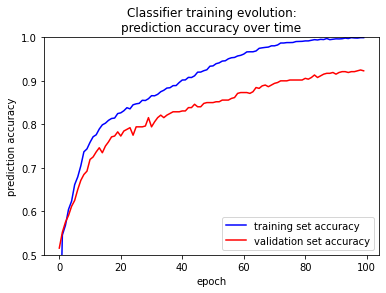

In [22]:
import matplotlib.pyplot as plt

epochs_list = list(range(epochs))

plt.figure()
plt.plot(epochs_list, train_accs, 'b-', label='training set accuracy')
plt.plot(epochs_list, val_accs, 'r-', label='validation set accuracy')
plt.xlabel('epoch')
plt.ylabel('prediction accuracy')
plt.ylim(0.5, 1)
plt.title('Classifier training evolution:\nprediction accuracy over time')
plt.legend()
plt.show()

The model obtained a validation accuracy of 92.5% once fully trained, which means that out of the validation set of 520 images, it correctly classified about 480 of them as either cancerous or non-cancerous.

You may also notice that the model overfit to the training set. This could have been mitigated with some sort of regularization, but that is beyond the scope of this introductory tutorial.

This performance is good, but we will only know the true ability of the model to classify new data by evaluating it on the test set, as follows.

## (5) Testing your best model
Now that our model is trained, how well does it do on test set? We can test this with the following code, where I also show a few classification examples; this is very similar to how we evaluated on the validation set.

### A Word on Measuring a Classifier's Performance in Medical Image Analysis
In medical image analysis, it is common to report further performance metrics than solely classification accuracy, to better analyze how the classifier is doing. A *false positive* (FP) is when a classifier mis-classifies a negative (cancer-free) image as positive, and a *true positive* (TP) is when a positive image is correctly classified. Let's estimate these as well in our code:

/tmp/ipykernel_620/11095997.py:32: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  img = img.astype(np.float) * 255. / img.max()


Example Images:


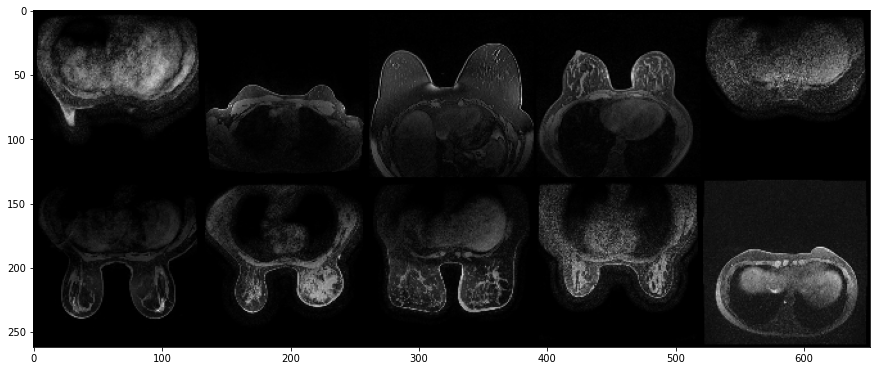

Target labels:
[0, 0, 0, 0, 0, 1, 1, 0, 1, 0]
Classifier predictions:
[0, 0, 0, 0, 0, 1, 1, 0, 1, 0]
Test set accuracy: 0.9442307692307692
238 true positive classifications, 19 false positive classifications


In [36]:
# for data visualization
from torchvision.utils import make_grid

# helper function for plotting a batch of images
def plot_imgbatch(imgs):
    imgs = imgs.cpu()
    imgs = imgs.type(torch.IntTensor)
    plt.figure(figsize=(15, 3*(imgs.shape[0])))
    grid_img = make_grid(imgs, nrow=5)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.show()

total_test_examples = 0
num_correct_test = 0

# true and false positive counts
false_pos_count = 0
true_pos_count = 0

# visualize a random batch of data with examples
num_viz = 10
viz_index = random.randint(0, len(test_dataset)//eval_batchsize)

# see how well the final trained model does on the test set
with torch.no_grad(): # don't save parameter gradients/changes since this is not for model training
		for batch_index, (inputs, targets) in enumerate(test_loader):
			# make predictions
			inputs = inputs.to(device)
			targets = targets.to(device)
			predictions = net_final(inputs)

			# compute prediction statistics
			_, predicted_class = predictions.max(1)
			total_test_examples += predicted_class.size(0)
			num_correct_test += predicted_class.eq(targets).sum().item()
            
			# thanks to https://gist.github.com/the-bass/cae9f3976866776dea17a5049013258d
			confusion_vector = predicted_class / targets
			# Element-wise division of the 2 tensors returns a new tensor which holds a
			# unique value for each case:
			#   1     where prediction and truth are 1 (True Positive)
			#   inf   where prediction is 1 and truth is 0 (False Positive)

			num_true_pos = torch.sum(confusion_vector == 1).item()
			num_false_pos = torch.sum(confusion_vector == float('inf')).item()
            
			true_pos_count += num_true_pos
			false_pos_count += num_false_pos

			# plot predictions
			if batch_index == viz_index:
				print('Example Images:')
				plot_imgbatch(inputs[:num_viz])
				print('Target labels:')
				print(targets[:num_viz].tolist())
				print('Classifier predictions:')
				print(predicted_class[:num_viz].tolist())



# get total results
# total prediction accuracy of network on test set
test_acc = num_correct_test / total_test_examples
print("Test set accuracy: {}".format(test_acc))
print("{} true positive classifications, {} false positive classifications".format(true_pos_count, false_pos_count))

On our test set of 520 unseen examples, we got a prediction accuracy of 94.4% for our cancer detection task! Out of 257 positive (cancer) classifications, 238, or about 93%, were true positives, while 19 (about 7%) were false positives.

## Conclusion
In this tutorial, I showed how to train a breast MRI classification model via deep learning with PyTorch, on our DBC-MRI dataset. 

In Part 1, I introduced the DICOM medical imaging datatype, showed to obtain the data from the Cancer Imaging Archive, and showed how to extract images from the data in a format useful for PyTorch.

In this part, I showed how to load, train and test a classification neural network on the MRI data.

I wrote these blog posts to provide an introductory example of how to use neural networks for the realistic application of medical image analysis. This only scratches the surface of the wide array of medical image analysis (MIA) applications of deep learning. For those interested in learning more, check out: 
1. The [most recent proceedings of the MICCAI conference](https://miccai2021.org/openaccess/paperlinks/) for a look into state-of-the-art MIA research). 
2. The journals [Medical Image Analysis](https://www.journals.elsevier.com/medical-image-analysis) and [Transactions on Medical Imaging](https://ieeexplore.ieee.org/xpl/RecentIssue.jsp?punumber=42).
3. Scholarly publications by [my lab's advisor](https://scholar.google.com/citations?user=HlxjJPQAAAAJ&hl=en) and [myself](https://scholar.google.com/citations?user=a9rXidMAAAAJ&hl=en).

Thanks for reading!